In [102]:
import pandas as pd

df = pd.read_csv("data.csv", sep="\t")

In [103]:
df["Datum"] = pd.to_datetime(df["Datum"], format="%Y%m%d")
df["Einkaufsumsatz"] = pd.to_numeric(df.Einkaufsumsatz, errors="coerce")
df["Verkaufsumsatz"] = pd.to_numeric(df.Verkaufsumsatz, errors="coerce")
df = df.astype(
    {
        "Firmennummer": int,
        "Kundennummer": int,
        "Artikelnummer": int,
        "Auftragsnummer": int,
        "Menge": int,
    }
)
df = df[(df["Einkaufsumsatz"] != 0) & (df["Einkaufsumsatz"].notna())]
df = df[(df["Verkaufsumsatz"] > 1) & (df["Verkaufsumsatz"].notna())]
df = df[df.Einkaufsumsatz < df.Verkaufsumsatz]
df.reset_index(drop=True)

,Firmennummer,Kundennummer,Artikelnummer,Auftragsnummer,Datum,Menge,Verkaufsumsatz,Einkaufsumsatz
0,927,19641,29354,51576,2023-01-02,1,129.59,72.67
1,373,33067,29354,5091,2023-01-02,1,166.80,69.87
2,196,24985,29354,87202,2023-01-02,1,151.15,72.67
3,115,68780,29354,57081,2023-01-02,1,202.80,72.67
4,822,54298,29354,40754,2023-01-02,1,150.49,72.67
...,...,...,...,...,...,...,...,...
51314,318,95314,10595,62074,2024-08-01,3,40.97,15.28
51315,511,21883,10595,66616,2024-08-01,3,41.83,21.67
51316,903,15695,10595,45901,2024-08-01,48,561.02,274.52
51317,511,46485,10595,76046,2024-08-01,3,27.14,14.93


In [104]:
df = df.assign(
    sale_per_unit=df.Verkaufsumsatz / df.Menge,
    buy_per_unit=df.Einkaufsumsatz / df.Menge,
    margin=lambda df: df.sale_per_unit - df.buy_per_unit,
)
df

,Firmennummer,Kundennummer,Artikelnummer,Auftragsnummer,Datum,Menge,Verkaufsumsatz,Einkaufsumsatz,sale_per_unit,buy_per_unit,margin
0,927,19641,29354,51576,2023-01-02,1,129.59,72.67,129.590000,72.670000,56.920000
1,373,33067,29354,5091,2023-01-02,1,166.80,69.87,166.800000,69.870000,96.930000
2,196,24985,29354,87202,2023-01-02,1,151.15,72.67,151.150000,72.670000,78.480000
3,115,68780,29354,57081,2023-01-02,1,202.80,72.67,202.800000,72.670000,130.130000
4,822,54298,29354,40754,2023-01-02,1,150.49,72.67,150.490000,72.670000,77.820000
...,...,...,...,...,...,...,...,...,...,...,...
65442,318,95314,10595,62074,2024-08-01,3,40.97,15.28,13.656667,5.093333,8.563333
65443,511,21883,10595,66616,2024-08-01,3,41.83,21.67,13.943333,7.223333,6.720000
65444,903,15695,10595,45901,2024-08-01,48,561.02,274.52,11.687917,5.719167,5.968750
65445,511,46485,10595,76046,2024-08-01,3,27.14,14.93,9.046667,4.976667,4.070000


In [105]:
aggregated = (
    df.groupby(["Artikelnummer", "sale_per_unit"])
    .agg(sold_units=("Menge", "sum"), unique_days=("Datum", "nunique"))
    .reset_index()
    .assign(sales_per_day=lambda df: df.sold_units / df.unique_days)
)
aggregated

,Artikelnummer,sale_per_unit,sold_units,unique_days,sales_per_day
0,10595,4.308000,15,1,15.0
1,10595,5.268000,15,1,15.0
2,10595,5.435833,12,1,12.0
3,10595,5.529000,60,1,60.0
4,10595,5.529012,162,1,162.0
...,...,...,...,...,...
8798,91161,10.812308,13,1,13.0
8799,91161,10.823636,11,1,11.0
8800,91161,10.824000,20,2,10.0
8801,91161,10.824000,15,1,15.0


In [106]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from scipy.optimize import curve_fit


def paf_linear(x, slope, intercept):
    return slope * x + intercept


def paf_exp(x, a, b):
    return a * x**-b


def plot(filtered):

    slope, intercept, _, _, _ = stats.linregress(
        x=filtered.sale_per_unit, y=filtered.sales_per_day
    )

    optimized_parameters, _ = curve_fit(
        paf_exp,
        filtered.sale_per_unit,
        filtered.sales_per_day,
        bounds=([0, 0], [np.inf, np.inf]),
        maxfev=1000,
    )

    y_lin = [paf_linear(x, slope, intercept) for x in filtered.sale_per_unit]
    y_exp = [paf_exp(x, *optimized_parameters) for x in filtered.sale_per_unit]

    plt.figure(figsize=(10, 5))
    plt.scatter(filtered.sale_per_unit, filtered.sales_per_day, alpha=0.2)

    plt.plot(filtered.sale_per_unit, y_lin, color="black", label="Linear")
    plt.plot(filtered.sale_per_unit, y_exp, color="red", label="Exponentiell")

    plt.xlabel("Preis in €")
    plt.ylabel("Verkäufe")
    plt.title(
        f"Durchschnittliche Verkäufe pro Tag\n"
        f"Parameter der linearen PAF: a (Intercept): {intercept:.2f}, b (Slope): {slope:.2f}"
    )
    plt.legend(title="PAF")
    plt.ylim([round(min(y_lin + y_exp) * 1.5), round(max(y_lin + y_exp) * 2)])
    plt.grid()
    plt.show()

10595


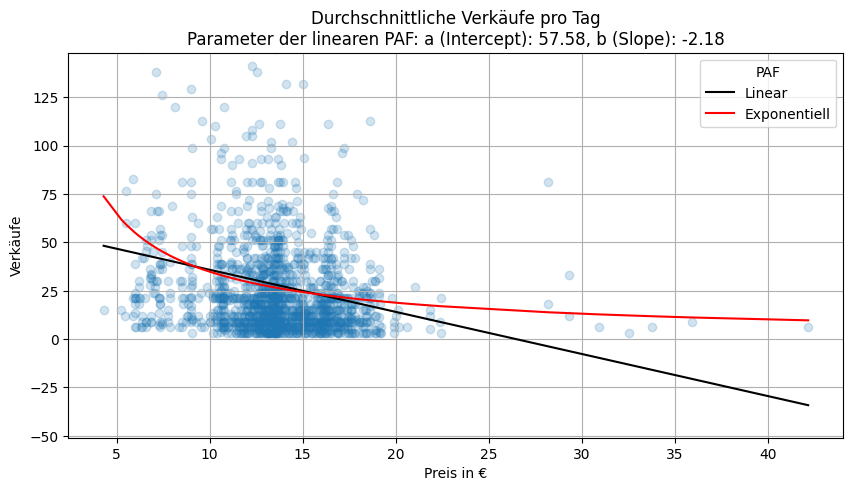

22060


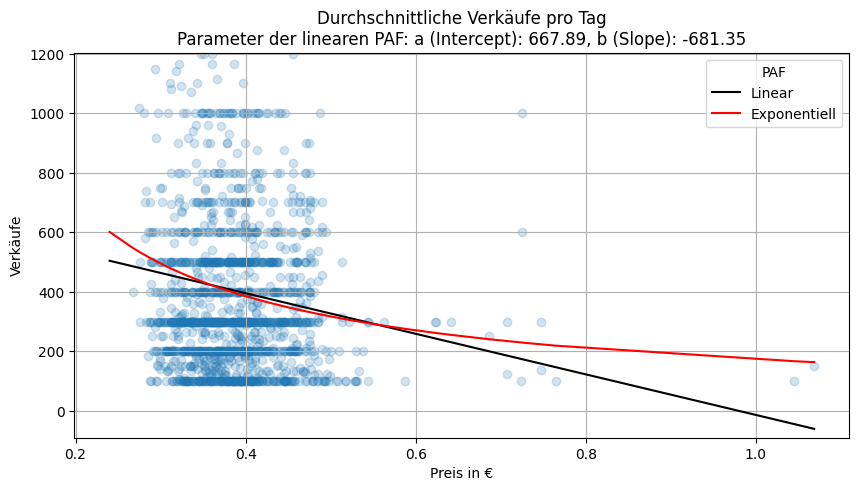

29354


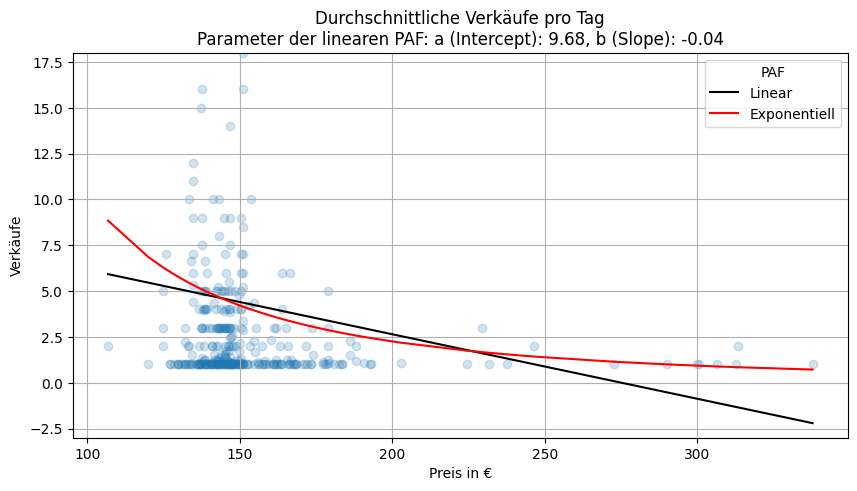

34980


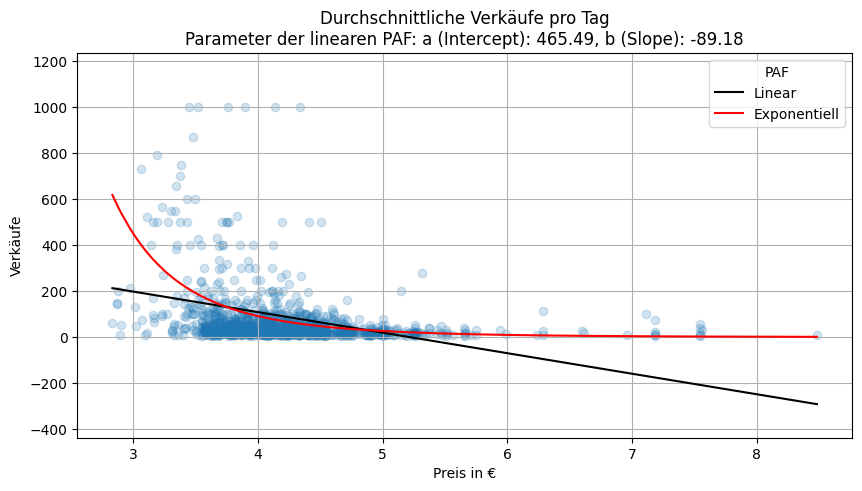

53675


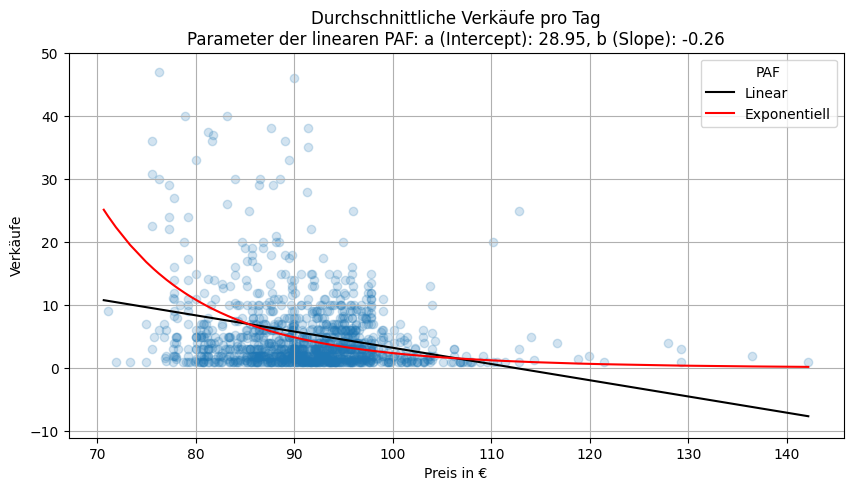

64569


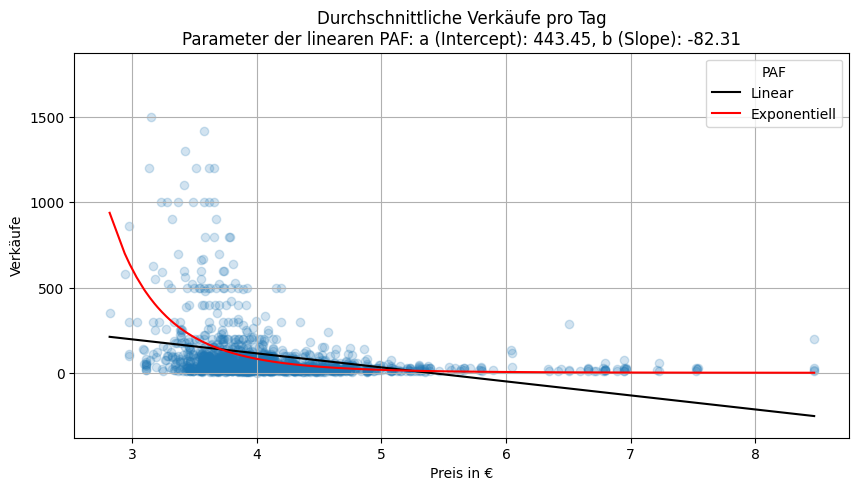

91161


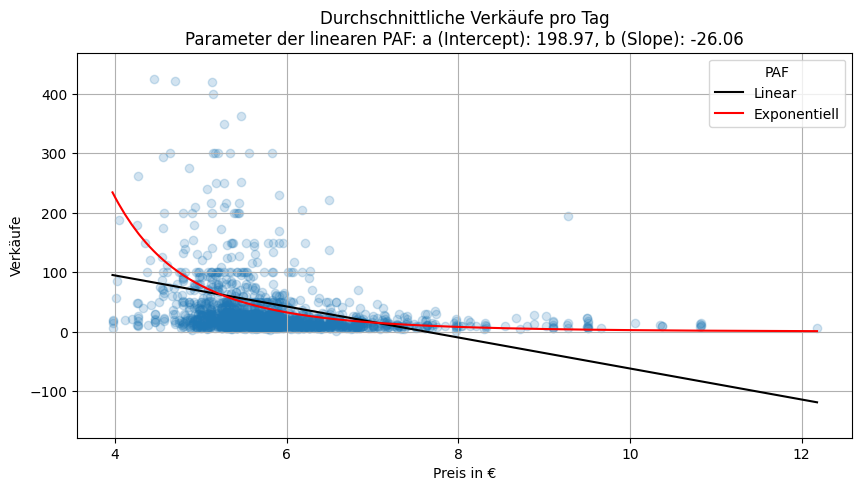

In [107]:
for article_id in aggregated.Artikelnummer.unique():
    filtered = aggregated[aggregated.Artikelnummer == article_id]
    print(article_id)
    plot(filtered)

In [108]:
import numpy as np
import warnings

warnings.warn = lambda *args, **kwargs: None


def calculate_lin_parameters(group):
    price = group.sale_per_unit.values
    sales = group.sales_per_day.values

    # Matrix für lineare Regression (y = a - b*p)
    X = np.vstack([np.ones_like(price), price]).T

    # Least Squares Regression: X @ (a, b) = y lösen
    (a, b), _, _, _ = np.linalg.lstsq(X, sales, rcond=None)

    return pd.Series({"a": a, "b": b})

In [109]:
%%timeit

aggregated.groupby("Artikelnummer").apply(calculate_lin_parameters)

4.72 ms ± 457 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [110]:
parameters = (
    aggregated.groupby("Artikelnummer").apply(calculate_lin_parameters).reset_index()
)
parameters

,Artikelnummer,a,b
0,10595,57.578810,-2.175477
1,22060,667.885950,-681.346099
2,29354,9.682253,-0.035197
3,34980,465.494412,-89.177942
4,53675,28.947183,-0.256977
5,64569,443.445301,-82.306166
6,91161,198.971063,-26.063406


In [111]:
avg_buy = df.groupby("Artikelnummer").buy_per_unit.mean().reset_index()

pd.merge(parameters, avg_buy, on="Artikelnummer").assign(
    optimal_sale=lambda df: (df.a + df.buy_per_unit * -df.b) / (2 * -df.b)
)

,Artikelnummer,a,b,buy_per_unit,optimal_sale
0,10595,57.578810,-2.175477,6.584122,16.525664
1,22060,667.885950,-681.346099,0.184453,0.582349
2,29354,9.682253,-0.035197,71.662610,173.376160
3,34980,465.494412,-89.177942,2.051160,3.635499
4,53675,28.947183,-0.256977,46.776991,79.710903
5,64569,443.445301,-82.306166,2.071016,3.729384
6,91161,198.971063,-26.063406,2.953361,5.293738


In [112]:
higher_layer = df.assign(group=lambda df: df.Artikelnummer % 2)

higher_layer_aggregated = (
    higher_layer.groupby(["group", "sale_per_unit"])
    .agg(sold_units=("Menge", "sum"), unique_days=("Datum", "nunique"))
    .reset_index()
    .assign(sales_per_day=lambda df: df.sold_units / df.unique_days)
)
higher_layer_parameters = higher_layer_aggregated.groupby("group").apply(
    calculate_lin_parameters
)
higher_layer_avg_buy = higher_layer.groupby("group").buy_per_unit.mean().reset_index()

pd.merge(higher_layer_parameters, higher_layer_avg_buy, on="group").assign(
    optimal_sale=lambda df: (df.a + df.buy_per_unit * -df.b) / (2 * -df.b)
)

,group,a,b,buy_per_unit,optimal_sale
0,0,272.171659,-1.789873,13.796896,82.929444
1,1,67.919985,-0.741641,16.004180,53.792449




> Wie kann man das Problem lösen, dass lineare PAF keine konstante Preiselastizität haben?

**Die Unkonstanz ist eine inhärente Eigenschaft der linearen PAF.**

Preiselastizität der Nachfrage

$
\varepsilon = \frac{\text{relative Änderung im Absatz}}{\text{relative Änderung im Preis}} = \frac{dPAF}{dp} \cdot \frac{p}{PAF}
$

Im Speziellen für eine lineare PAF:

$
PAF(p) = a - b p
$, $a$ und $b$ konstant.

Dann ist die Ableitung:

$
\frac{dPAF}{dp} = -b
$

Elastizität einer linearen PAF:

$
\varepsilon(p) = \frac{-b p}{a - b p}
$



Für eine konstante Elastizität können wir eine Exponentialfunktion verwenden:

$
PAF(p) = a \cdot p^{-b}
$, $a$ und $b$ konstant.

Dann ist die Ableitung:

$
\frac{dPAF}{dp} = -b \cdot a \cdot p^{-b -1}
$

Und dann folgt:
$
\varepsilon(p) = -b
$


> Wie kann man aus der PAF rohertragsoptimierende Preise berechnen?

$
PAF(p) = a - b p
$

Gewinn ist dann:

$
G(p) = PAF(p) \cdot (p - p_{einkauf})
$

Maximieren der Gewinnfunktion, wenn Ableitung $\frac{dG}{dp}=0$

$
\frac{dG}{dp} = (a - bp) + (p - p_{einkauf})(-b) = 0
$

$
a - 2bp + p_{einkauf}b = 0
$

$
p_{optimal} = \frac{a+p_{einkauf}b}{2b}
$